In [119]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

# Asset Universe and Market Caps

In [120]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

In [121]:
data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("historical_data.csv")

closing_prices = data["Adj Close"]

returns = np.log(closing_prices / closing_prices.shift(1).dropna())

market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

market_caps = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info["marketCap"]

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


<Axes: >

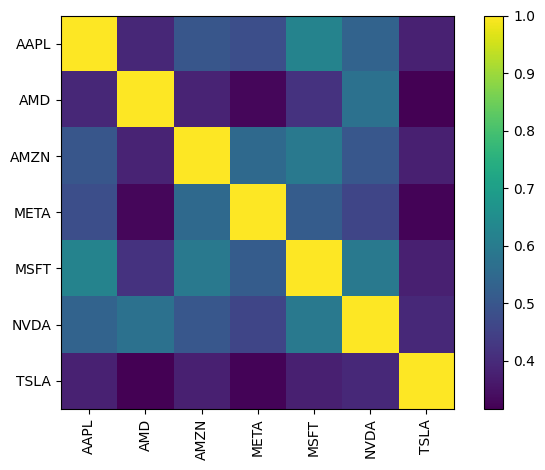

In [122]:
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

# Delta (risk aversion) and Prior (market equillibrium returns)

Delta: 4.088019988131726
Priors: Ticker
AAPL    0.020994
AMD     0.021481
AMZN    0.021080
META    0.021169
MSFT    0.020978
NVDA    0.021690
TSLA    0.021460
dtype: float64


<Axes: ylabel='Ticker'>

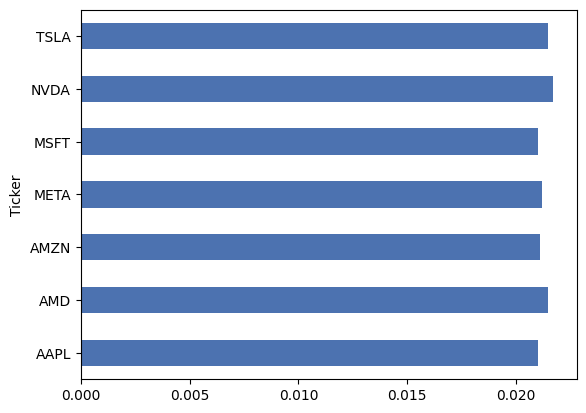

In [141]:
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

print(f"Delta: {delta}")
print(f"Priors: {prior}")

prior.plot.barh()

# Custom Fear Greed Index

In [125]:
# Generate views based on FG for Model 2

# get indiv FG indicators here (split into separeate file later)

# indicators to define:
# done - Stock Price Momentum: A measure of the S&P 500 versus its 125-day moving average (MA)
# done - Stock Price Strength: The number of stocks hitting 52-week highs versus those hitting 52-week lows on the New York Stock Exchange (NYSE).
# done - Stock Price Breadth: Analyzing the trading volumes in rising stocks against declining stocks.
# Put and Call Options: The extent to which put options lag behind call options, signifying greed, or surpasses them, indicating fear.
# Junk Bond Demand: Measures the spread between yields on investment-grade bonds and junk bonds.
# Market Volatility: The CBOE's Volatility Index (VIX) based on a 50-day MA.
# Safe Haven Demand: The difference in returns for stocks versus treasuries.

# custom fear greed score calculator - to give specific score for a given stock
# which can then be used to influence the investor views (more accurately/better reflection of sentiment)
def get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    if isinstance(tickers, str):
        tickers = [tickers]

    fg_scores = {}
    for ticker in tickers:
        try:
            # calculate each indicator for the stock
            rsi = calculate_indiv_rsi(ticker, start_date=start_date, end_date=end_date).iloc[-1]['RSI']
            price_strength, high, low, current_price = stock_price_strength(ticker)
            breadth_data = stock_price_breadth(ticker, start=start_date, end=end_date)

            # normalise each indicator (as rsi is from 0-100 etc)
            normalised_rsi = rsi / 100
            normalised_price_strength = price_strength
            latest_breadth_ratio = breadth_data['breadth_ratio'].iloc[-1]
            normalised_breadth = min(max(latest_breadth_ratio / 2, 0), 1)

            # weights for each indicator
            rsi_weight = 0.4
            price_strength_weight = 0.3
            breadth_weight = 0.3

            # calculate the FG score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight
            )

            fg_scores[ticker] = fear_greed_score

        except KeyError:
            print(f"Data unavailable for {ticker}.")
            fg_scores[ticker] = None
        except Exception as e:
            print(f"An error occurred for {ticker}: {e}")
            fg_scores[ticker] = None

    return fg_scores

# Relative Strength Index (RSI)
def calculate_indiv_rsi(ticker, period=14, start_date="2023-01-01", end_date="2024-01-01"):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Change'] = stock_data['Close'].diff()

    stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
    stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)
    stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
    stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

    stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
    stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

    return stock_data[['Close', 'RSI']].dropna()

def stock_price_strength(ticker):
    stock_data = yf.Ticker(ticker)
    stock_history = stock_data.history(period="1y")

    high = stock_history['Close'].max()
    low = stock_history['Close'].min()
    current_price = stock_history['Close'].iloc[-1]

    proximity_to_high = (current_price - low) / (high - low)
    return proximity_to_high, high, low, current_price

def stock_price_breadth(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)['Close']
    volume_data = yf.download(ticker, start=start, end=end)['Volume']

    price_change = data.pct_change().fillna(0)
    results = pd.DataFrame(index=data.index)

    results['rising_volume'] = np.where(price_change > 0, volume_data, 0)
    results['declining_volume'] = np.where(price_change < 0, volume_data, 0)

    results['breadth_ratio'] = results['rising_volume'].sum() / results['declining_volume'].sum()
    return results


In [126]:
tickers = ['NVDA', 'AAPL'] # use any here. need to be using full asset universe for investor views
fear_greed_scores = get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01')
print(fear_greed_scores) # 0-1, higher score is greedier

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'NVDA': 0.7536334442004792, 'AAPL': 0.611086281123317}


In [127]:
def plot_rsi(ticker: str, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    rsi_data = calculate_indiv_rsi(ticker, start_date=start_date, end_date=end_date)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'{ticker} Relative Strength Index (RSI)')
    
    ax1.plot(rsi_data.index, rsi_data['RSI'], label='RSI', color='purple')
    ax1.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax1.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax1.set_ylabel('RSI')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    
    plt.show()

def plot_stock_price_strength(ticker: str):
    proximity_to_high, high, low, current_price = stock_price_strength(ticker)

    stock_data = yf.Ticker(ticker)
    stock_history = stock_data.history(period="1y")

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'{ticker} Stock Price and Strength Relative to 52-Week Range')
    
    ax1.plot(stock_history.index, stock_history['Close'], label='Close price', color='blue')
    ax1.axhline(high, color='red', linestyle='--', label='52 week high')
    ax1.axhline(low, color='green', linestyle='--', label='52 week low')
    ax1.scatter(stock_history.index[-1], current_price, color='purple', label=f'Current Price (Proximity: {proximity_to_high:.2f})')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    
    plt.show()

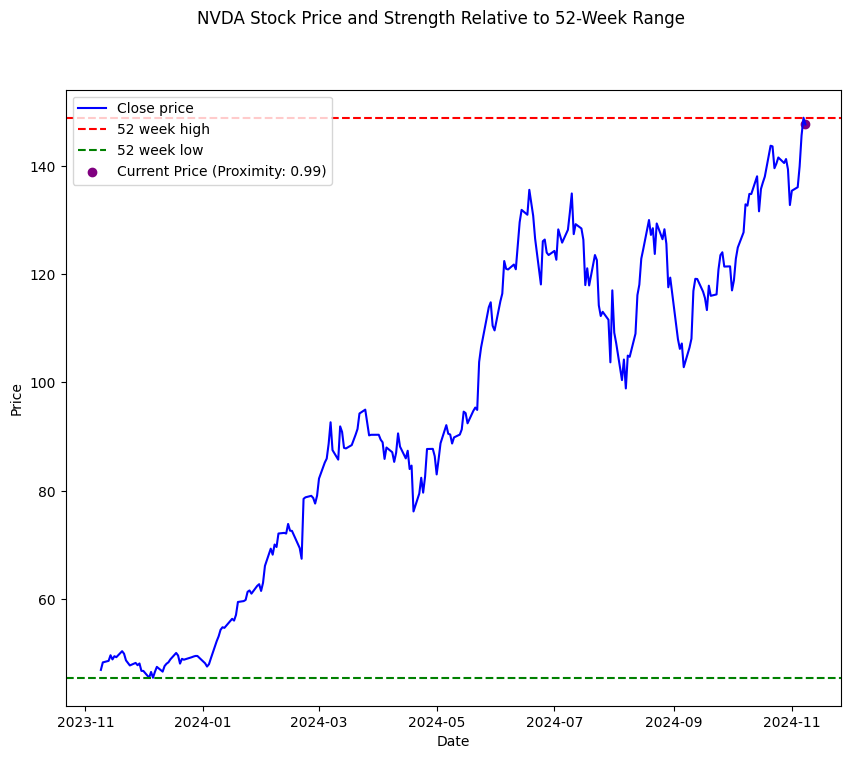

In [128]:
stock_strength = plot_stock_price_strength('NVDA') # change this to plot multiple

[*********************100%***********************]  1 of 1 completed


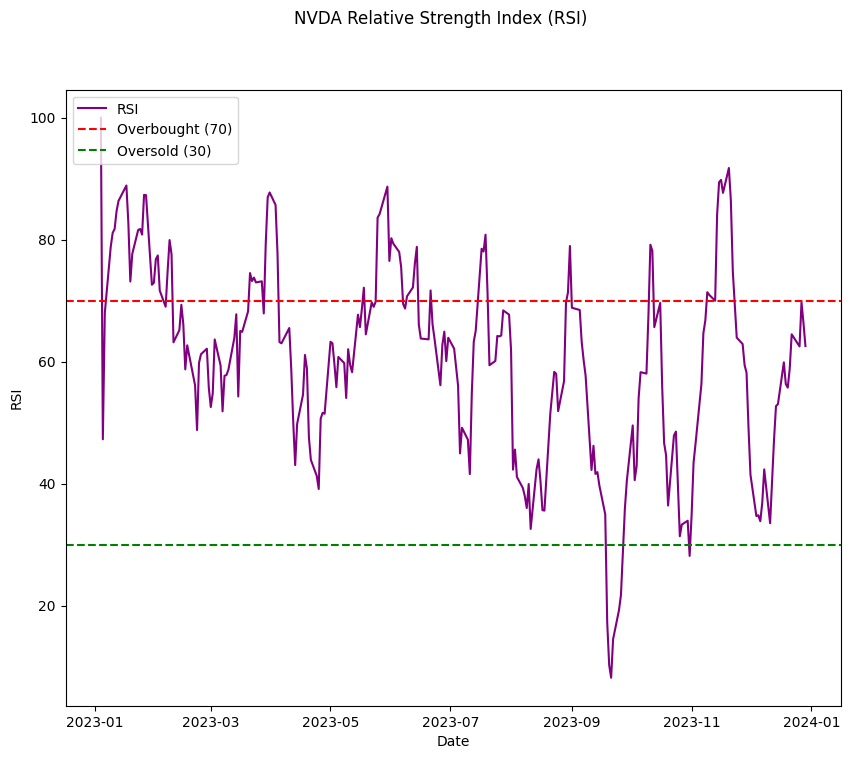

In [129]:
plot_rsi('NVDA')

# Investor Views

In [130]:
# Model 1 (standard views)
view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07} # Absolute views

view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7, 0.8]

bl = BlackLittermanModel(covariance_matrix, pi=prior, absolute_views=view_dict, view_confidences=view_confidences)

In [131]:
# Model 2 (fear greed views)

bl = BlackLittermanModel(covariance_matrix, pi=prior, absolute_views=view_dict, view_confidences=view_confidences)

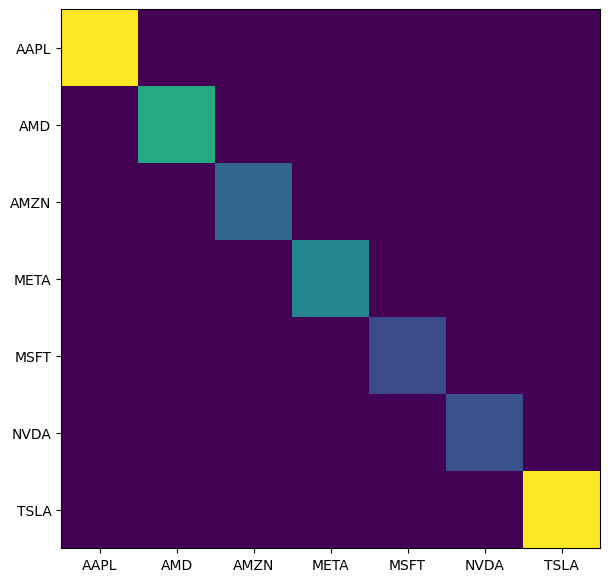

array([6.36894890e-05, 3.89966327e-05, 2.10670593e-05, 2.92956271e-05,
       1.43178074e-05, 1.60304670e-05, 6.36971609e-05])

In [142]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

np.diag(bl.omega)

# Posterior Returns

In [134]:
# Calculate posterior returns

bl = BlackLittermanModel(covariance_matrix, pi="market", market_caps=market_caps, risk_aversion=delta, absolute_views=view_dict, omega=bl.omega)

bl_returns = bl.bl_returns()
bl_returns

Ticker
AAPL    0.033706
AMD     0.054653
AMZN    0.028569
META    0.026746
MSFT    0.030655
NVDA    0.054607
TSLA    0.038325
dtype: float64

In [135]:
returns_df = pd.DataFrame([prior, bl_returns, pd.Series(view_dict)], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AAPL,0.020994,0.033706,0.05
AMD,0.021481,0.054653,0.07
AMZN,0.021080,0.028569,0.03
META,0.021169,0.026746,0.02
MSFT,0.020978,0.030655,0.04
NVDA,0.021690,0.054607,0.08
TSLA,0.021460,0.038325,0.04


<Axes: >

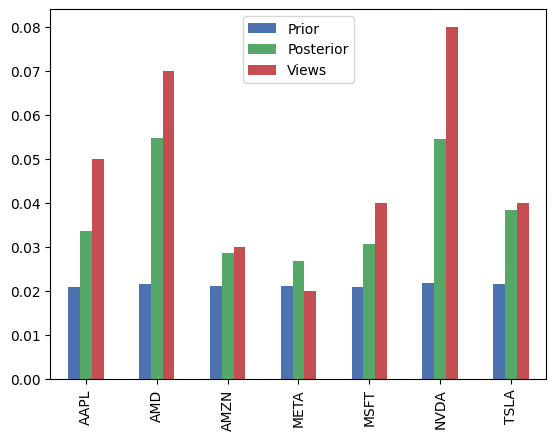

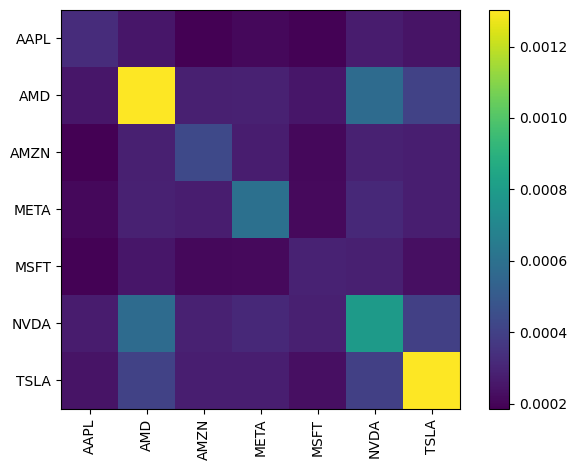

In [143]:
# visualisation of above
returns_df.plot.bar()

# posterior covariance matrix
posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

# Efficient Frontier Weights

In [138]:
ef = EfficientFrontier(bl_returns, posterior_cov)
weights = ef.min_volatility() # max_sharpe not working. look into this
cleaned_weights = ef.clean_weights()

In [139]:
cleaned_weights # why is there no weight for 3 stocks?

OrderedDict([('AAPL', 0.3542),
             ('AMD', 0.0),
             ('AMZN', 0.16226),
             ('META', 0.04388),
             ('MSFT', 0.43967),
             ('NVDA', 0.0),
             ('TSLA', 0.0)])

In [145]:
model_1_allocations = pd.Series(cleaned_weights).plot.pie()

AttributeError: 'collections.OrderedDict' object has no attribute 'index'